In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2023-08-18 14:19:58.025483: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 14:19:58.152588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 14:19:58.680200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-18 14:19:59.335401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 14:19:59.400479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 14:19:59.400590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), 'src'))

model_dir = os.path.join(os.getcwd(), 'model')
results_dir = os.path.join(os.getcwd(), 'results')
heatmap_dir = os.path.join(os.getcwd(), 'heatmap')

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if not os.path.exists(heatmap_dir):
    os.makedirs(heatmap_dir)

In [3]:
import pandas as pd

df = pd.read_csv('dataset.csv')
df.head()

,Sample ID,Cancer Type,Mutation Count,Sex,Sample Type,DNA Input,Matched Status,Oncotree Code,Overall Survival Status,Patient's Vital Status,...,VHL,VTCN1,WT1,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZRSR2
0,P-0000036-T01-IM3,Non-Small Cell Lung Cancer,3,Female,Primary,50.0,Unmatched,LUAD,0:LIVING,ALIVE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P-0000047-T01-IM3,Mesothelioma,2,Male,Primary,250.0,Matched,PLEMESO,1:DECEASED,DECEASED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P-0000058-T01-IM3,Breast Cancer,1,Female,Metastasis,144.0,Matched,IDC,0:LIVING,ALIVE,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,P-0000068-T01-IM3,Bladder Cancer,4,Male,Primary,250.0,Matched,BLCA,1:DECEASED,DECEASED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P-0000187-T01-IM3,Breast Cancer,6,Female,Metastasis,250.0,Matched,BRCANOS,1:DECEASED,DECEASED,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
grouped = df.groupby('Cancer Type').filter(lambda x: len(x) >= 30)
df = df[df['Cancer Type'].isin(grouped['Cancer Type'].unique())]

df_status = df.groupby('Cancer Type').size().reset_index(name='counts')
df_status

,Cancer Type,counts
0,Bladder Cancer,42
1,Bone Cancer,54
2,Breast Cancer,242
3,Cancer of Unknown Primary,43
4,Colorectal Cancer,100
5,Endometrial Cancer,32
6,Esophagogastric Cancer,63
7,Glioma,158
8,Head and Neck Cancer,35
9,Hepatobiliary Cancer,70


In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize

classes = pd.unique(df['Cancer Type'])
n_classes = len(pd.unique(classes))
del df['Sample ID']

le = LabelBinarizer()
y_df = df['Cancer Type']
del df['Cancer Type']
object_cols = list(df.select_dtypes(include='object'))
other_cols = list(df.select_dtypes(exclude='object'))
ohe_encoded_data = pd.get_dummies(df, columns=object_cols, drop_first=False)
encoded_data = pd.concat([ohe_encoded_data, df[other_cols]], axis=1)

encoded_data = pd.DataFrame(normalize(encoded_data))
encoded_data['label'] = list(y_df.values)

encoded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2171,2172,2173,2174,2175,2176,2177,2178,2179,label
0,0.042274,0.704575,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-Small Cell Lung Cancer
1,0.004905,0.706307,0.014715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Breast Cancer
2,0.011304,0.706485,0.025433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bladder Cancer
3,0.016671,0.694627,0.130590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Breast Cancer
4,0.005406,0.675715,0.208120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non-Small Cell Lung Cancer


In [6]:
encoded_data.to_csv('encoded-dataset.csv', index=False)
encoded_data.shape

(1754, 2181)

In [7]:
from sklearn.model_selection import train_test_split

x = list(encoded_data.iloc[:, :-1].values)
y = list(encoded_data.iloc[:, -1].values)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'No. of train inputs: {len(x_train)}')
print(f'No. of test inputs: {len(x_test)}')

No. of train inputs: 1403
No. of test inputs: 351


In [8]:
from sklearn.decomposition import PCA

pca = PCA()
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [9]:
x_train.shape

(1403, 1403)

In [10]:
import numpy as np
import tensorflow as tf
import keras
from keras import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential

x_train = np.array(x_train)
y_train_ohe = le.fit_transform(y_train).astype(np.float32)

model_path = os.path.join(model_dir, "model.keras")

if os.path.exists(model_path):
    model = keras.models.load_model(model_path)

else:
    model = Sequential()    
    model.add(Input(shape=x_train.shape[1]))
    model.add(Dense(1754, activation='relu'))
    for _ in range(5):
        model.add(Dense(750, activation='relu'))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    
    history = model.fit(x_train, y_train_ohe, batch_size=64, epochs=1000, validation_split=0.2,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)])
    model.save(model_path)    

Epoch 1/1000


2023-08-18 14:20:10.366768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 14:20:10.366900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-18 14:20:10.366979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

18/18 [==============================] - 3s 19ms/step - loss: 3.4252 - accuracy: 0.1159 - precision: 0.2454 - recall: 0.0472 - auc: 0.5696 - val_loss: 2.6715 - val_accuracy: 0.1459 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7177
Epoch 2/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.9810 - accuracy: 0.1988 - precision: 0.3043 - recall: 0.0624 - auc: 0.6370 - val_loss: 2.5772 - val_accuracy: 0.1851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7269
Epoch 3/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.7015 - accuracy: 0.2389 - precision: 0.4248 - recall: 0.0856 - auc: 0.6887 - val_loss: 2.5250 - val_accuracy: 0.1851 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7151
Epoch 4/1000
18/18 [==============================] - 0s 7ms/step - loss: 2.4516 - accuracy: 0.2906 - precision: 0.5323 - recall: 0.1176 - auc: 0.7388 - val_loss: 2.5591 - val_accuracy: 0.1851 - val_precision: 0.0000e+00

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1754)              2462616   
                                                                 
 dense_1 (Dense)             (None, 750)               1316250   
                                                                 
 dropout (Dropout)           (None, 750)               0         
                                                                 
 batch_normalization (Batch  (None, 750)               3000      
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 750)               563250    
                                                                 
 dropout_1 (Dropout)         (None, 750)               0         
                                                        

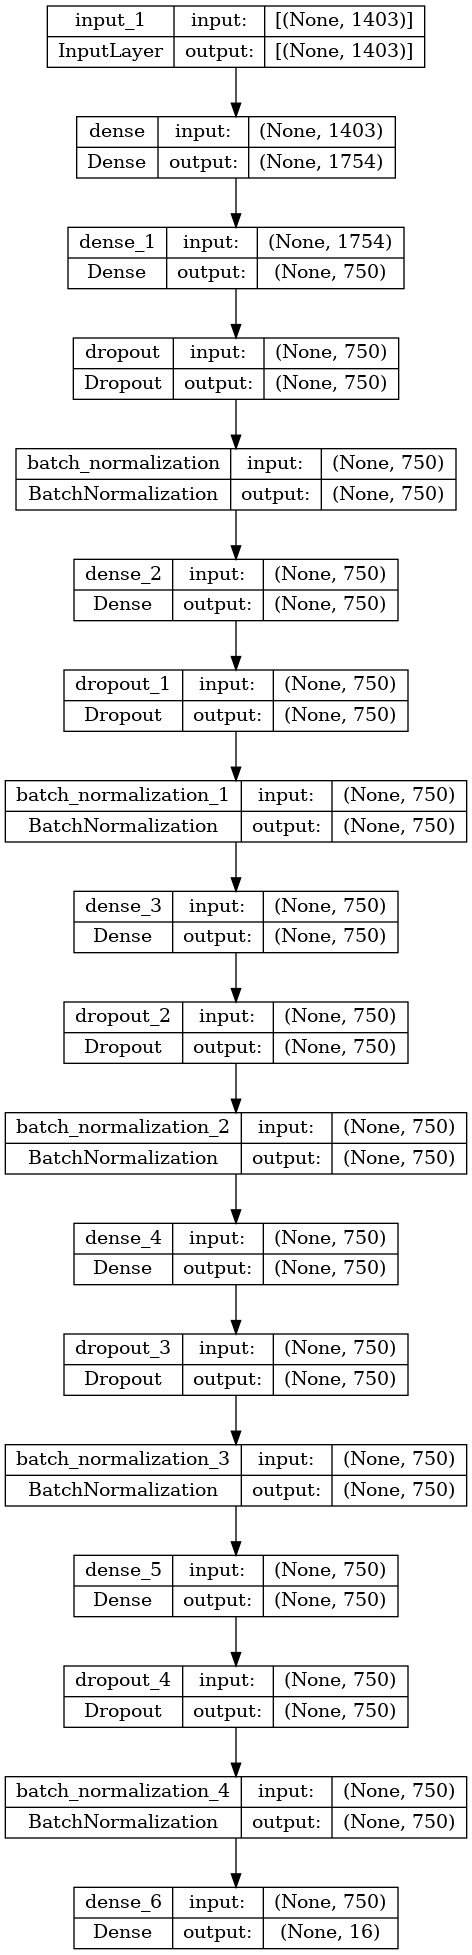

In [12]:
from keras.utils import plot_model

plot_model(model, os.path.join(model_dir, "model.png"), show_shapes=True)

In [45]:
x_test = np.array(x_test)
y_test_ohe = le.transform(y_test).astype(np.float32)

y_true = np.argmax(y_test_ohe, axis=-1)
y_preds = np.argmax(model.predict(x_test), axis=-1)

11/11 [==============================] - 0s 747us/step


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

precision, recall, f_score, _ = precision_recall_fscore_support(
    y_true,
    y_preds,
    average='weighted',
    zero_division=1
)

print(f'Accuracy score: {accuracy_score(y_true, y_preds)}')
print(f'Balanced accuracy score: {balanced_accuracy_score(y_true, y_preds)}')
print(f'Precision score: {precision}')
print(f'Recall score: {recall}')
print(f'F1 score: {f_score}\n')

print(classification_report(
    y_true,
    y_preds,
    digits=3,
    zero_division=1,
    target_names=le.classes_
))

Accuracy score: 0.7977207977207977
Balanced accuracy score: 0.7380283981765507
Precision score: 0.8498966622902054
Recall score: 0.7977207977207977
F1 score: 0.7878678940637652

                            precision    recall  f1-score   support

            Bladder Cancer      0.889     1.000     0.941         8
               Bone Cancer      0.846     0.917     0.880        12
             Breast Cancer      0.768     1.000     0.869        43
 Cancer of Unknown Primary      0.667     0.833     0.741        12
         Colorectal Cancer      0.938     0.882     0.909        17
        Endometrial Cancer      1.000     0.182     0.308        11
    Esophagogastric Cancer      0.500     0.700     0.583        10
                    Glioma      0.944     0.739     0.829        23
      Head and Neck Cancer      0.750     0.500     0.600         6
      Hepatobiliary Cancer      0.522     0.923     0.667        13
                  Melanoma      0.619     0.867     0.722        15
Non-S

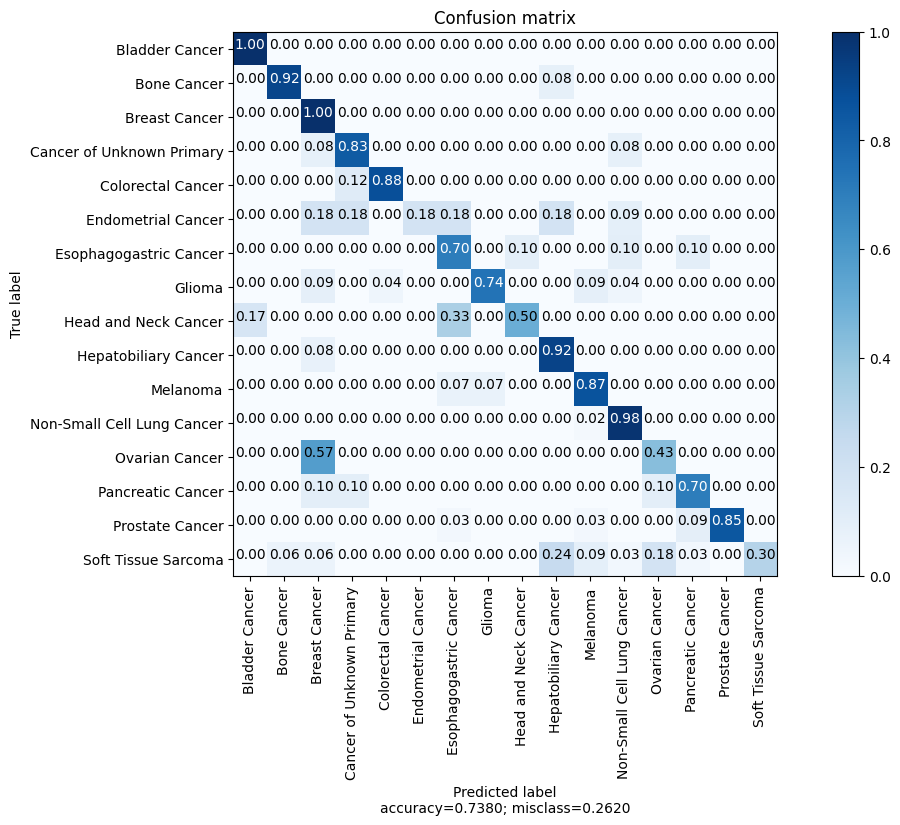

In [47]:
from sklearn.metrics import confusion_matrix
from src import plot_confusion_matrix

cm = confusion_matrix(y_true, y_preds, normalize='true')
plot_confusion_matrix(
    cm,
    le.classes_,
    os.path.join(results_dir, "model_cm.png")
)   

In [48]:
cm.diagonal() / cm.sum(axis=1)

array([1.        , 0.91666667, 1.        , 0.83333333, 0.88235294,
       0.18181818, 0.7       , 0.73913043, 0.5       , 0.92307692,
       0.86666667, 0.98245614, 0.42857143, 0.7       , 0.85135135,
       0.3030303 ])

In [51]:
from src import create_support_set
from src import create_couples

x_support, y_support = create_support_set(x_train, y_train, classes, 3)
x_train_left, x_train_right, y_train_set = create_couples(x_support, y_support, x_train, y_train)

In [52]:
from keras.layers import Lambda
from keras.layers import concatenate
from keras.models import Model
from src import AttentionLayer
import keras.backend as K

siamese_model_path = os.path.join(model_dir, "siamese_model.keras")

if os.path.exists(siamese_model_path):
    siamese_model = keras.models.load_model(siamese_model_path)

else:
    left_model = Sequential(model.layers[:-1])
    right_model = Sequential(model.layers[:-1])
    
    for layer in left_model.layers:
        layer.trainable = False
    for layer in right_model.layers:
        layer.trainable = False
    
    left_input = Input(shape=x_train_left.shape[1], name='left_input')
    right_input = Input(shape=x_train_right.shape[1], name='right_input')
    
    left_output = left_model(left_input)
    right_output = right_model(right_input)

    distance = Lambda(lambda x: K.sqrt(K.sum(K.square(x[0] - x[1]), axis=1, keepdims=True)))([left_output, right_output])

    attention, attention_weights = AttentionLayer()([left_output, right_output])
    combined_attention = concatenate([attention, distance])
    
    merged_output = Dense(320, activation="relu")(combined_attention)
    merged_output = Dropout(0.1)(merged_output)
    merged_output = BatchNormalization()(merged_output)
    merged_output = Dense(320, activation="relu")(merged_output)
    merged_output = Dropout(0.1)(merged_output)
    merged_output = BatchNormalization()(merged_output)
    merged_output = Dense(320, activation="relu")(merged_output)
    merged_output = Dropout(0.1)(merged_output)
    merged_output = BatchNormalization()(merged_output)
    
    output = Dense(1, activation='sigmoid', name='classification_output')(merged_output)

    siamese_model = Model(
        inputs=[left_input, right_input],
        outputs=[output, attention]
    )
    
    siamese_model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    
    history_siamese = siamese_model.fit(
        [x_train_left, x_train_right],
        y=y_train_set,
        batch_size=64,
        epochs=1000,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='classification_output_loss', patience=20, restore_best_weights=True)]
    )
    siamese_model.save(siamese_model_path)    

Epoch 1/1000
842/842 [==============================] - 6s 5ms/step - loss: 1.1224 - classification_output_loss: 0.1304 - attention_layer_1_loss: 0.9921 - classification_output_accuracy: 0.9601 - classification_output_precision_2: 0.7062 - classification_output_recall_2: 0.7526 - classification_output_auc_2: 0.9464 - attention_layer_1_accuracy: 0.8914 - attention_layer_1_precision_2: 0.3691 - attention_layer_1_recall_2: 0.7404 - attention_layer_1_auc_2: 0.8617 - val_loss: 1.6203 - val_classification_output_loss: 0.0766 - val_attention_layer_1_loss: 1.5437 - val_classification_output_accuracy: 0.9780 - val_classification_output_precision_2: 0.5593 - val_classification_output_recall_2: 0.9732 - val_classification_output_auc_2: 0.9966 - val_attention_layer_1_accuracy: 0.7808 - val_attention_layer_1_precision_2: 0.0668 - val_attention_layer_1_recall_2: 0.5335 - val_attention_layer_1_auc_2: 0.7416
Epoch 2/1000
842/842 [==============================] - 3s 4ms/step - loss: 1.5199 - classific

In [53]:
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 1403)]               0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 1403)]               0         []                            
                                                                                                  
 sequential_3 (Sequential)   (None, 750)                  6046866   ['left_input[0][0]']          
                                                                                                  
 sequential_4 (Sequential)   (None, 750)                  6046866   ['right_input[0][0]']         
                                                                                            

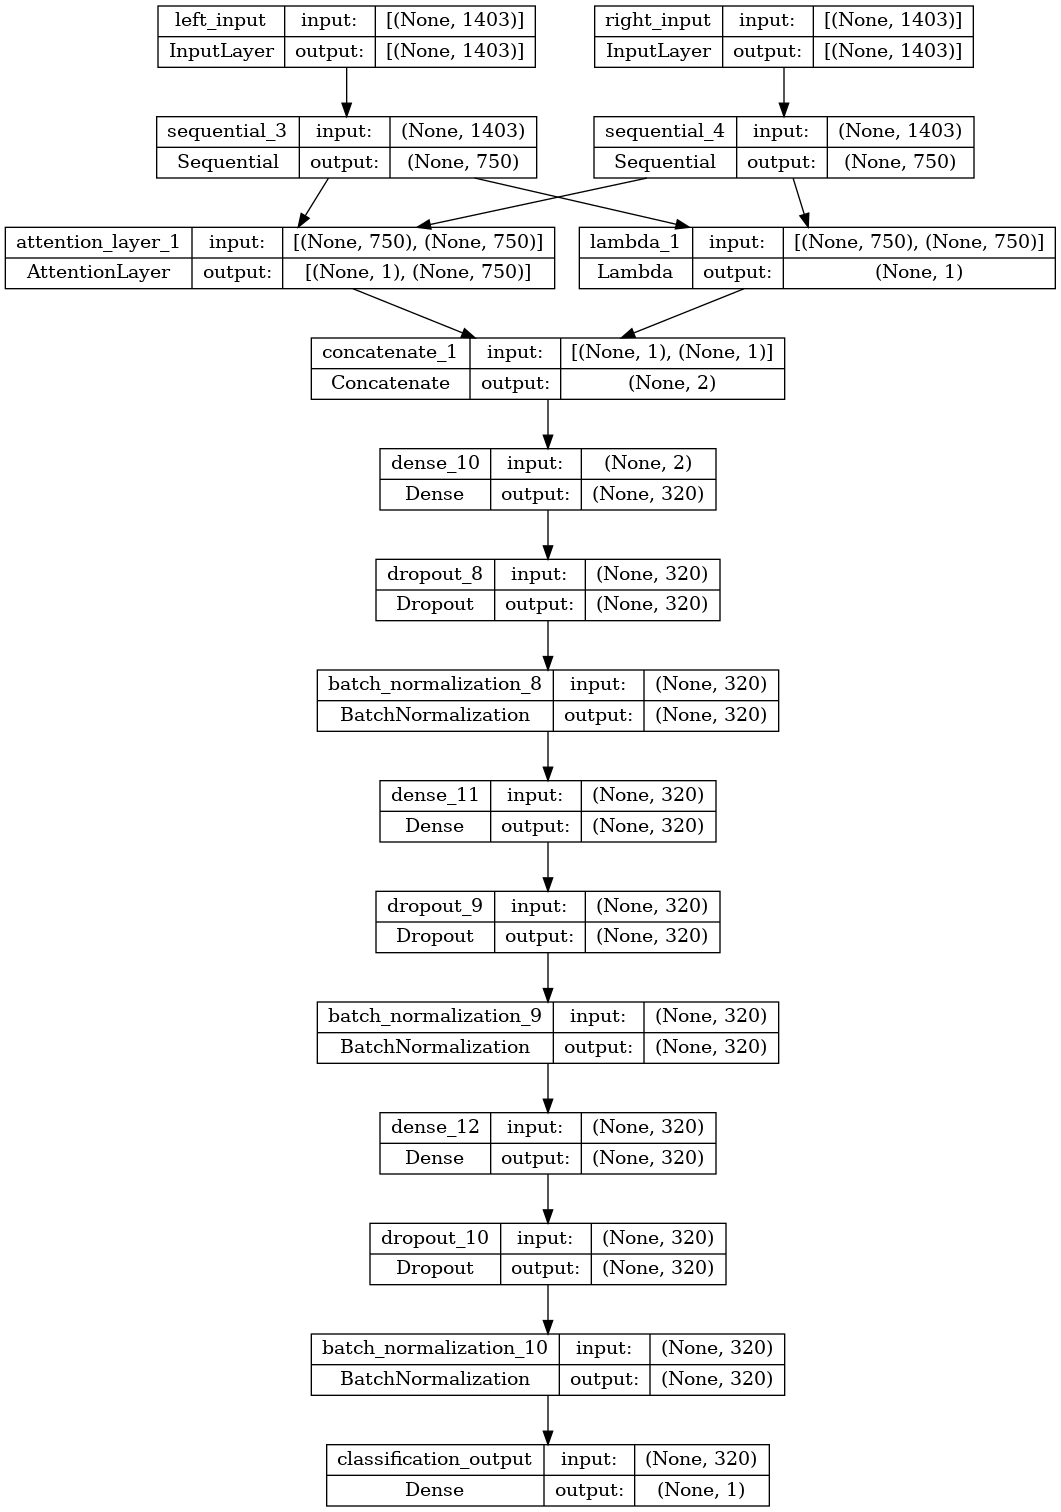

In [54]:
plot_model(siamese_model, os.path.join(model_dir, "siamese-model.png"), show_shapes=True)

In [55]:
x_test_left, x_test_right, y_test_set = create_couples(x_support, y_support, x_test, y_test)
y_true_siamese = np.array(y_test_set)

y_probs = np.array(siamese_model.predict([x_test_left, x_test_right])[0])
y_preds_siamese = y_probs.round()

527/527 [==============================] - 1s 1ms/step


In [56]:
precision, recall, f_score, _ = precision_recall_fscore_support(
    y_true_siamese,
    y_preds_siamese,
    average='weighted',
    zero_division=1
)

print(f'Accuracy score: {accuracy_score(y_true_siamese, y_preds_siamese)}')
print(f'Balanced accuracy score: {balanced_accuracy_score(y_true_siamese, y_preds_siamese)}')
print(f'Precision score: {precision}')
print(f'Recall score: {recall}')
print(f'F1 score: {f_score}\n')

print(classification_report(
    y_true_siamese,
    y_preds_siamese,
    digits=3,
    zero_division=1,
    target_names=['Not equal', 'Equal']
))

Accuracy score: 0.9763176638176638
Balanced accuracy score: 0.8925292814181702
Precision score: 0.9760299698045691
Recall score: 0.9763176638176638
F1 score: 0.9761631925143647

              precision    recall  f1-score   support

   Not equal      0.986     0.988     0.987     15795
       Equal      0.819     0.797     0.808      1053

    accuracy                          0.976     16848
   macro avg      0.903     0.893     0.898     16848
weighted avg      0.976     0.976     0.976     16848



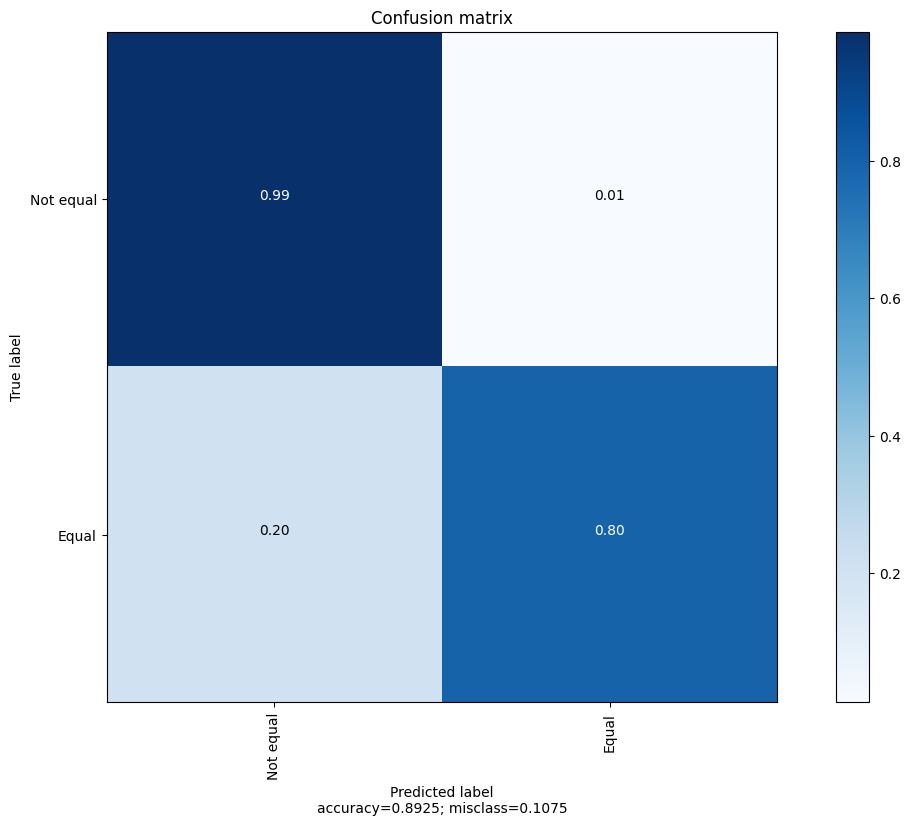

In [57]:
cm = confusion_matrix(y_true_siamese, y_preds_siamese, normalize='true')
plot_confusion_matrix(
    cm,
    ['Not equal', 'Equal'],
    os.path.join(results_dir, "siamese_model_binary_cm.png")
)   

In [58]:
accuracy_results = []

y_test = np.array(y_test)
for cancer in classes:
    indices = np.where(y_test == cancer)
    x_test_eval = x_test[indices]
    y_test_eval = y_test[indices]
    x_test_left, x_test_right, y_test_set = create_couples(x_support, y_support, x_test_eval, y_test_eval)
    results = siamese_model.predict([x_test_left, x_test_right])
    classification_results = np.array(results[0])
    y_preds_multi = classification_results.round()
    accuracy_results.append(balanced_accuracy_score(y_test_set, y_preds_multi))

15/15 [==============================] - 0s 1ms/step


In [60]:
print(list(zip(classes, accuracy_results)))

[('Non-Small Cell Lung Cancer', 0.9524366471734893), ('Breast Cancer', 0.9392764857881137), ('Bladder Cancer', 0.9069444444444444), ('Head and Neck Cancer', 0.9296296296296296), ('Bone Cancer', 0.9537037037037037), ('Soft Tissue Sarcoma', 0.7037037037037037), ('Prostate Cancer', 0.9605105105105105), ('Ovarian Cancer', 0.7984126984126985), ('Glioma', 0.8280193236714976), ('Esophagogastric Cancer', 0.79), ('Hepatobiliary Cancer', 0.8666666666666667), ('Colorectal Cancer', 0.9581699346405228), ('Cancer of Unknown Primary', 0.8314814814814815), ('Endometrial Cancer', 0.694949494949495), ('Melanoma', 0.9318518518518519), ('Pancreatic Cancer', 0.8333333333333333)]


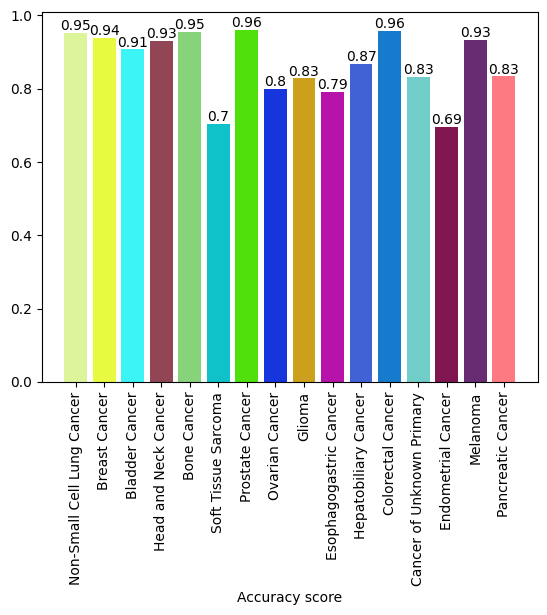

In [61]:
import matplotlib.pyplot as plt
from src.utils import generate_random_colors

fig, ax = plt.subplots()
random_colors = generate_random_colors(len(classes))
ax.bar(classes, accuracy_results, color=random_colors)
plt.xlabel('Accuracy score')
for i, value in enumerate(accuracy_results):
    plt.text(i, value, str(round(value, 2)), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=90)
plt.show()

1/1 [==============================] - 0s 10ms/step


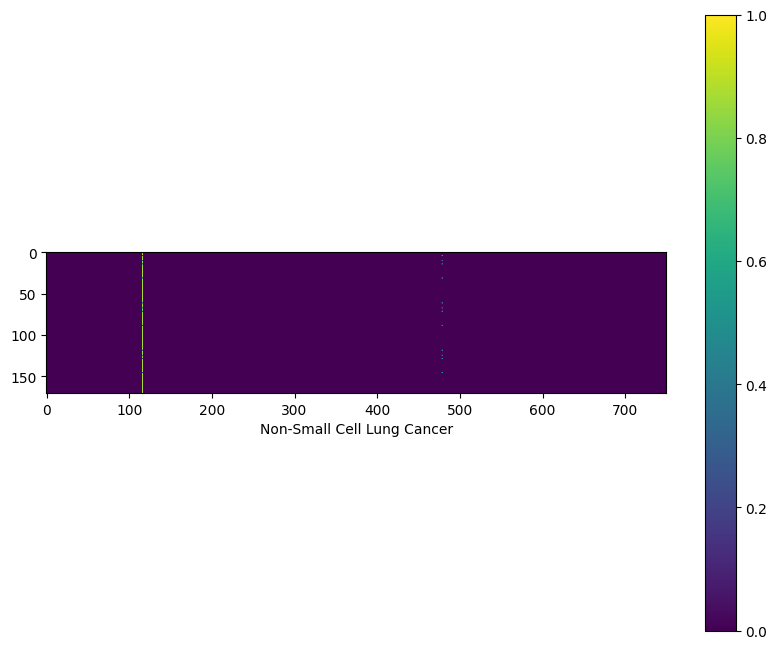

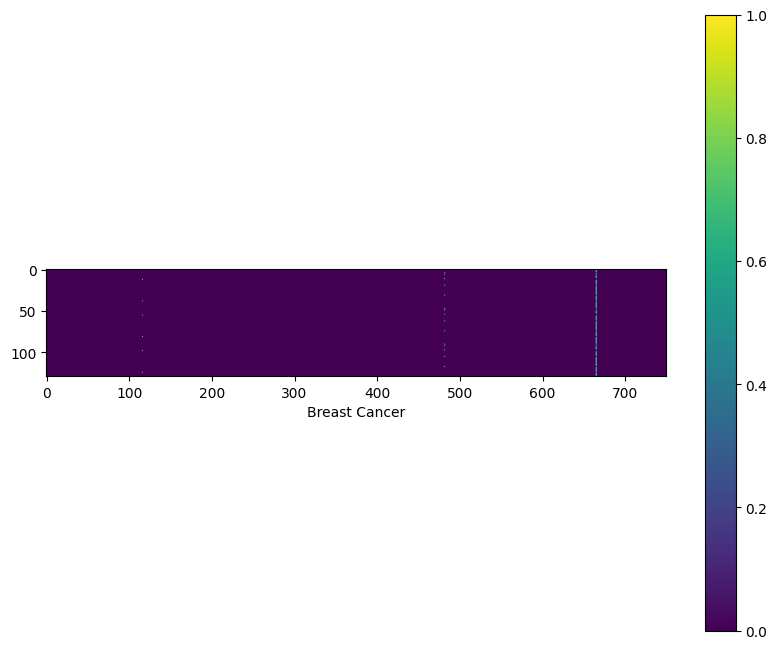

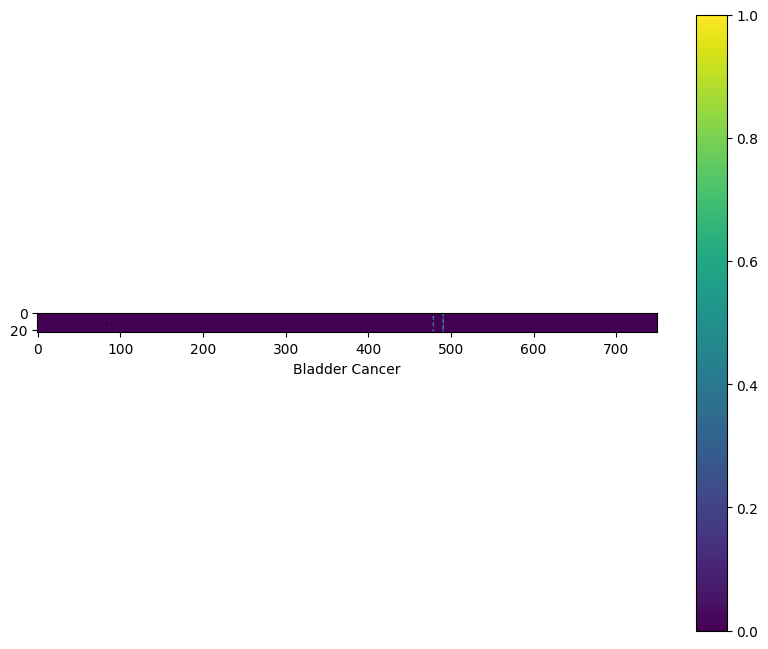

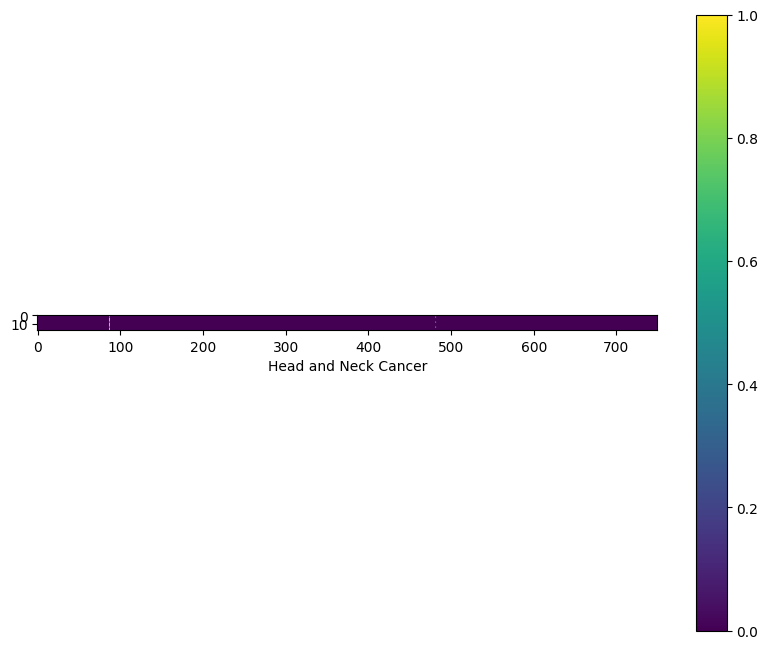

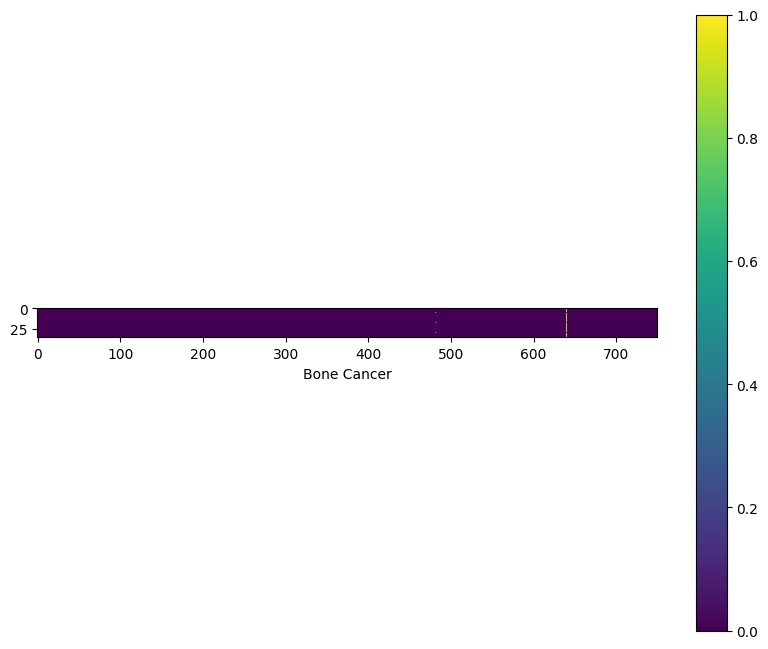

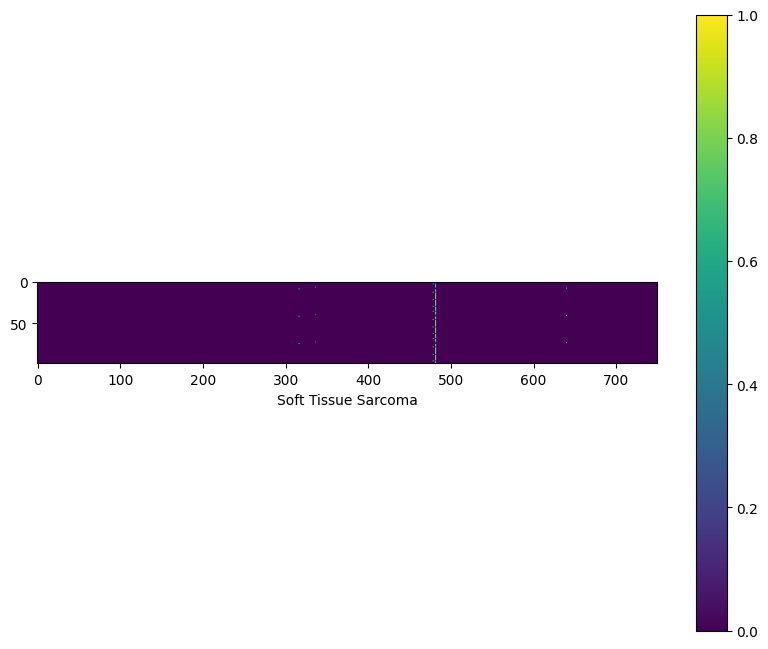

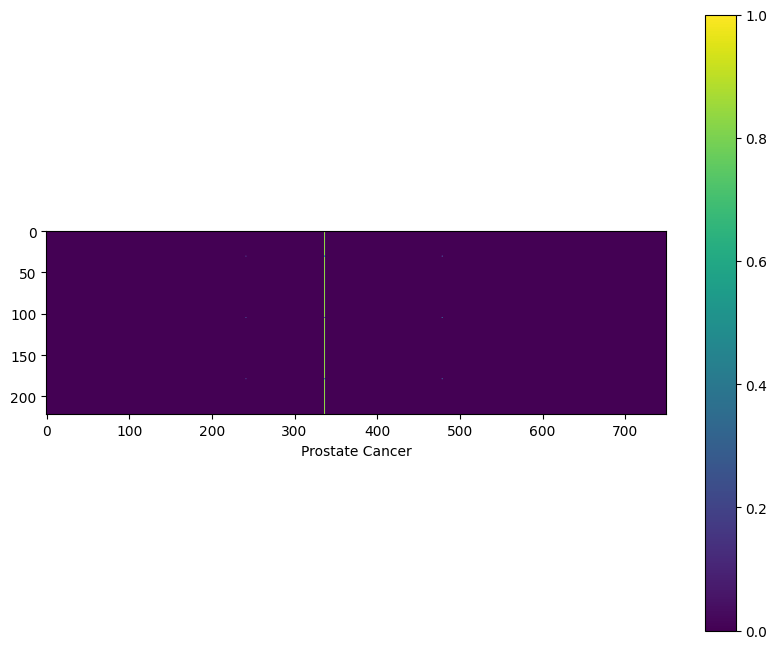

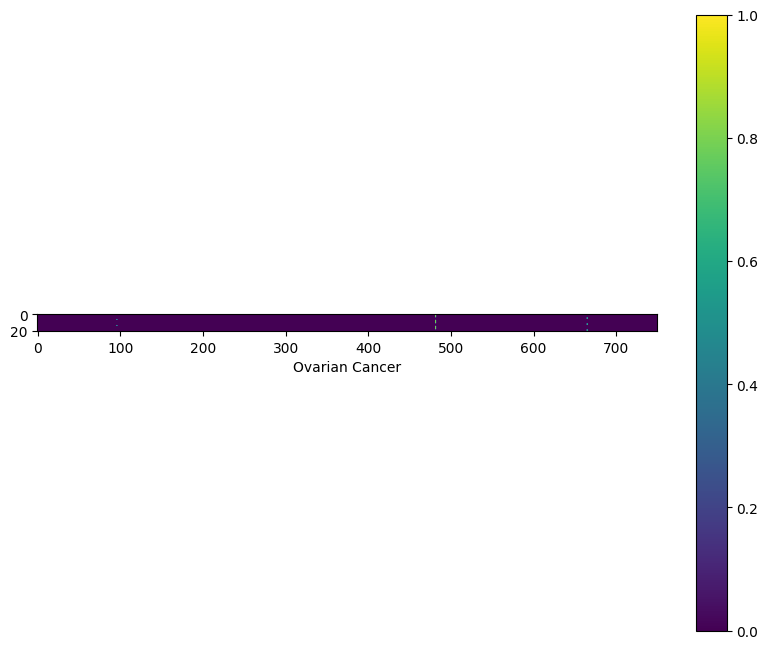

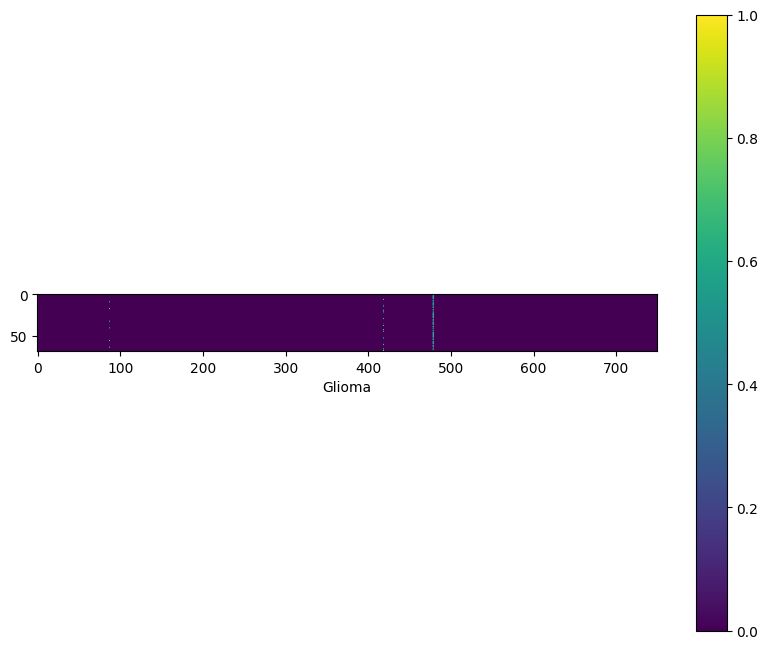

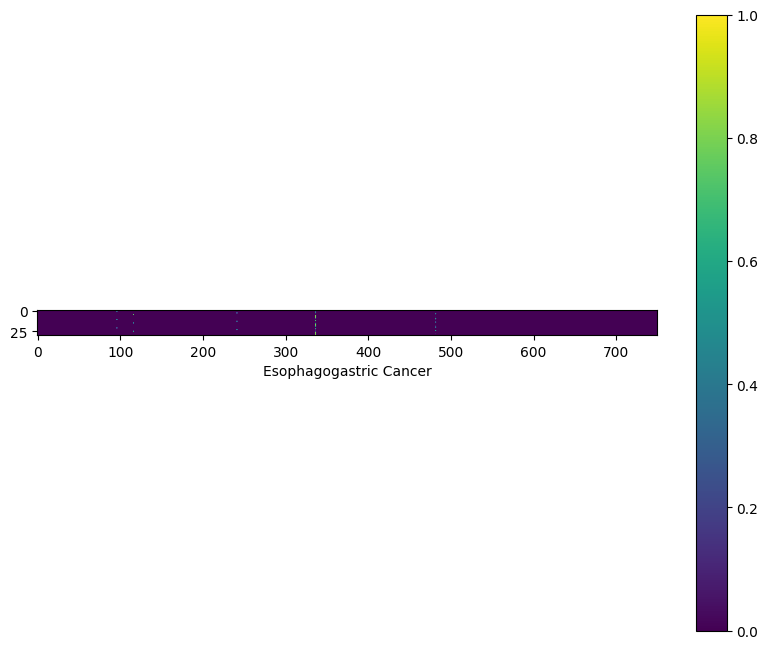

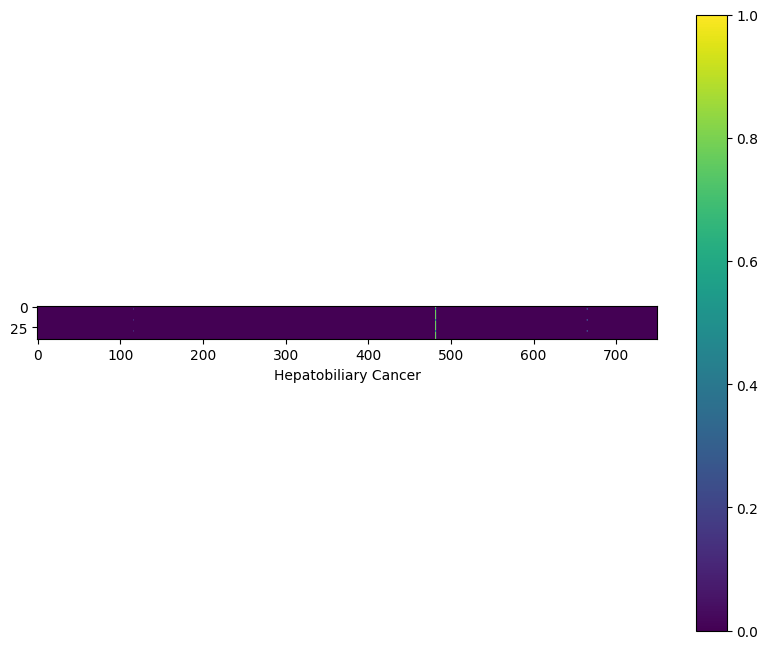

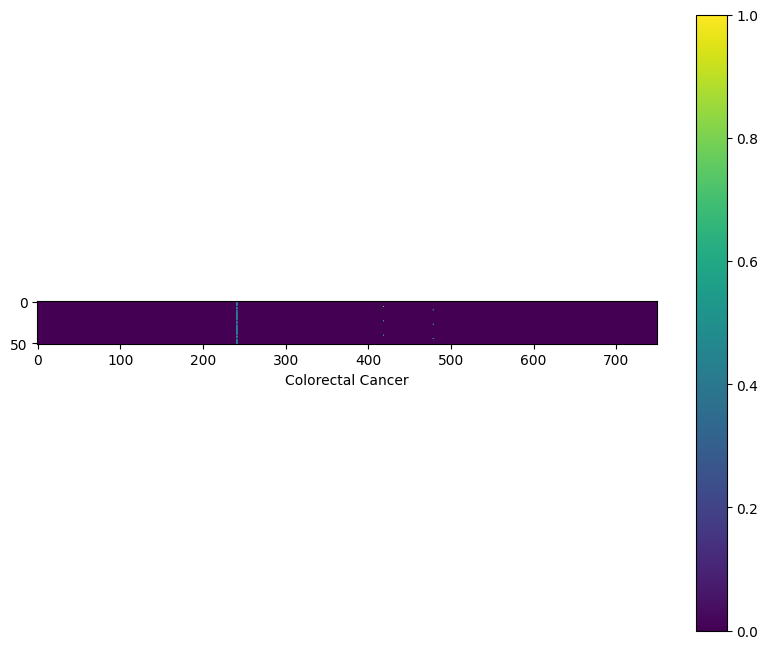

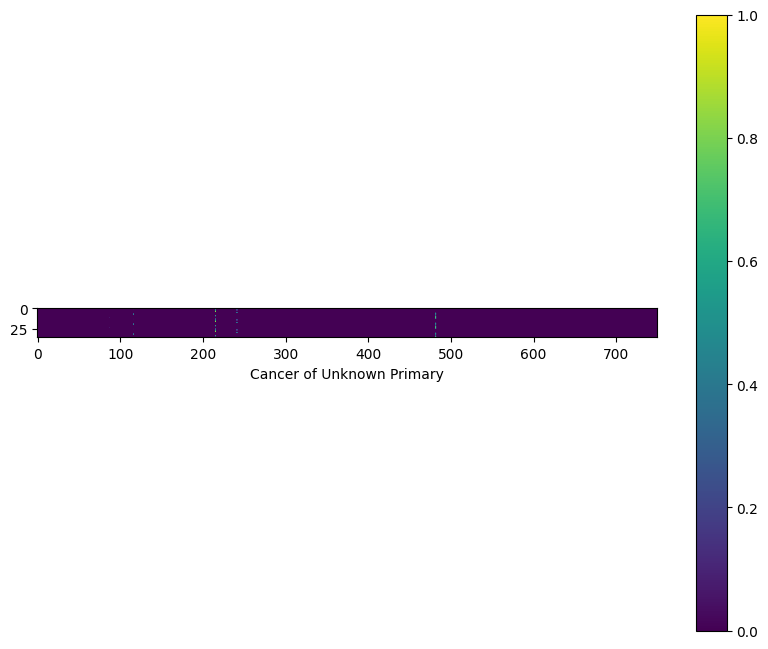

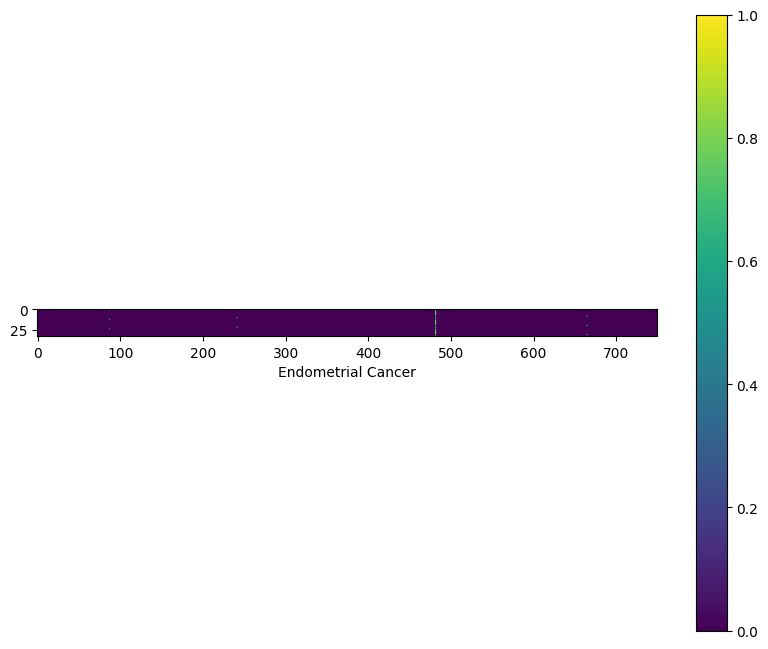

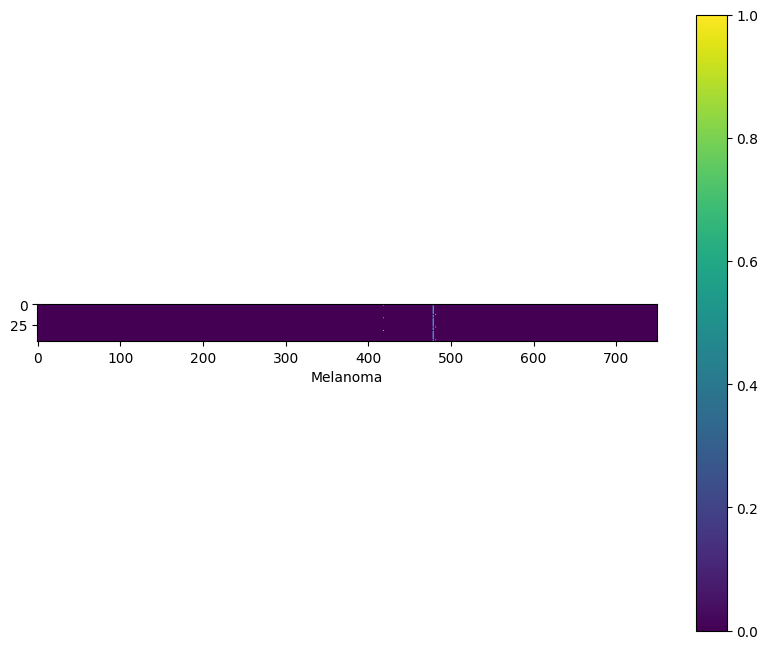

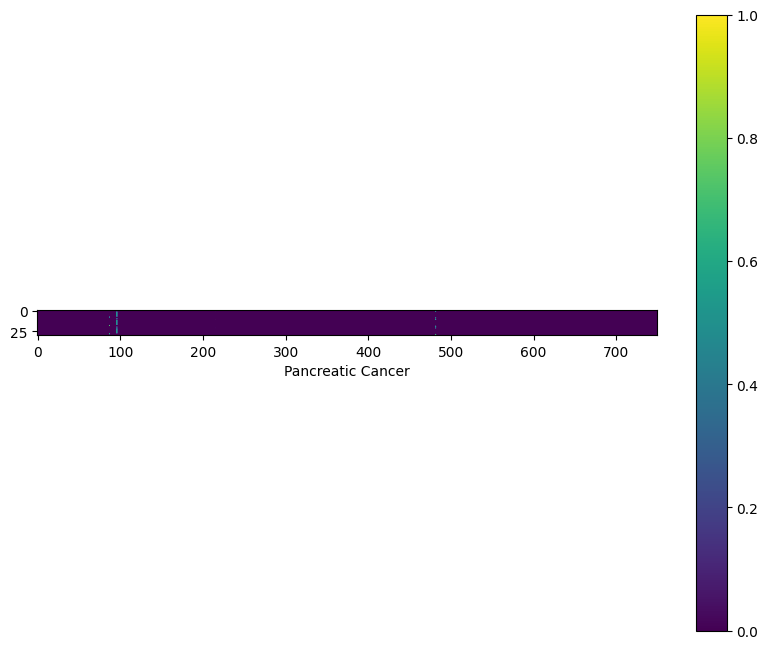

In [63]:
heatmap_model = Model(
    inputs=siamese_model.input,
    outputs=siamese_model.get_layer('attention_layer').output[1]
)

for cancer in classes:
    indices = np.where(y_test == cancer)
    x_test_eval = x_test[indices]
    y_test_eval = y_test[indices]
    x_test_left, x_test_right, y_test_set = create_couples(x_support, y_support, x_test_eval, y_test_eval)
    indices = np.where(y_test_set == 1)
    x_test_left = x_test_left[indices]
    x_test_right = x_test_right[indices]
    output = heatmap_model.predict([x_test_left, x_test_right])

    plt.figure(figsize=(10, 8))
    plt.xlabel(cancer)
    plt.imshow(output, cmap='viridis')
    plt.colorbar()
    plt.savefig(os.path.join(heatmap_dir, f'{cancer}_heatmap.png'))